In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 100)  # показывать больше строк
pd.set_option('display.max_columns', 100)  # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

In [2]:
# Смотрим какие типы данных присутствуют в выборке
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [3]:
# В выборке присутствует 13 числовых столбцов и 17 строковых. Но фактически только 2 показателя количественные
# Также в выборке присутствует поле "studytime, granular", которая полноностью коррелируется с полем studytime, поэтому его можно сразу дропнуть.
# У показателей famsize, Pstatus, Fedu, Mjob, Fjob, guardian, traveltime, paid, internet, romantic, famrel много пустых значений.
stud_math['studytime'].corr(stud_math['studytime, granular'])

-0.9999999999999991

In [4]:
stud_math.drop(['studytime, granular'], inplace=True, axis=1)

In [5]:
# приведем назнания столбцов к одному формату
stud_math = stud_math.rename(columns={"famsize": "fam_size", "Pstatus": "p_status", "Medu": "m_edu", "Fedu": "f_edu", "Mjob": "m_job", "Fjob": "f_job", "traveltime": "travel_time", "studytime": "study_time", "schoolsup": "school_sup", "famsup": "fam_sup", "famrel": "fam_rel", "freetime": "free_time", "goout": "go_out"
                                      })

In [6]:
# Далее проходим по каждому столбцу, чтобы проверить наличие ошибок или выбросов
# school: аббревиатура школы, в которой учится ученик
display(pd.DataFrame(stud_math.school.value_counts()))

,school
GP,349
MS,46


In [7]:
# Всего 2 школы, преимущественно ученики из школы GP
# sex пол ученика ('F' - женский, 'M' - мужской)
display(pd.DataFrame(stud_math.sex.value_counts()))

,sex
F,208
M,187


,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


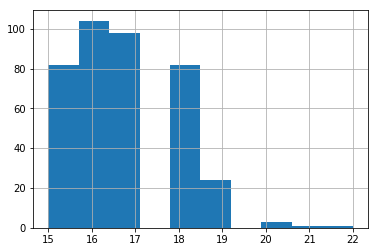

In [8]:
# Нет ошибок, гендерное распределение равномерно
# age — возраст ученика (от 15 до 22)
display(pd.DataFrame(stud_math.age.value_counts()))
stud_math.age.hist()

In [9]:
# В основном всем ученикам до 19 лет (вкл). Есть 5 учеников старше 19 лет, но для выборки не считаю это выбросами
# address — тип адреса ученика ('U' - городской, 'R' - за городом)
display(pd.DataFrame(stud_math.address.value_counts()))

,address
U,295
R,83


In [10]:
# В основном ученики живут в городе
# fam_size — размер семьи('LE3' <= 3, 'GT3' >3)
display(pd.DataFrame(stud_math.fam_size.value_counts()))

,fam_size
GT3,261
LE3,107


In [11]:
# В выборке присутстуют пустые значения NaN, которые мы не можем обработать. Заменим их на пустые значения
stud_math['fam_size'] = stud_math['fam_size'].fillna('')

In [12]:
# Больше трети учеников живут в семьях где больше 3 членов семьи
# p_status - статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
display(pd.DataFrame(stud_math.p_status.value_counts()))

,p_status
T,314
A,36


In [13]:
# Большинство родителей учеников живут вместе. Заполним пустые значения как Т, т.к. их большинство
stud_math['p_status'] = stud_math['p_status'].fillna('T')

In [14]:
# Большинство родителей учеников живут вместе.
# m_edu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
display(pd.DataFrame(stud_math.m_edu.value_counts()))

,m_edu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


In [15]:
# Большая часть матерей имеют закончили как минимум 9 классов
# f_edu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
display(pd.DataFrame(stud_math.f_edu.value_counts()))

,f_edu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


In [16]:
# В показателе образования отца присутствует один выброс, видимо ошибка. Можем точечно его исключить
# Пустые значения можем заменить на медианное значение
stud_math.drop(stud_math[stud_math['f_edu'] == 40].index, inplace=True)
f_edu_median = stud_math.f_edu.median()
stud_math['f_edu'] = stud_math['f_edu'].fillna(f_edu_median)

In [17]:
# Большая часть матерей имеют закончили как минимум 9 классов
# m_job — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
display(pd.DataFrame(stud_math.m_job.value_counts()))

,m_job
other,133
services,97
at_home,58
teacher,55
health,32


In [18]:
# Выборка распределена более менее равномерно. Пустые значения оставляем пустыми
stud_math['m_job'] = stud_math['m_job'].fillna('')

In [19]:
# f_job — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
display(pd.DataFrame(stud_math.f_job.value_counts()))

,f_job
other,196
services,102
teacher,29
at_home,16
health,15


In [20]:
# Меньшее количество отцов не работает или работает в сфере здравоохранения, чем матери. Пустые значения заполним как others
stud_math['f_job'] = stud_math['f_job'].fillna('other')

In [21]:
# reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
display(pd.DataFrame(stud_math.reason.value_counts()))

,reason
course,137
home,104
reputation,102
other,34


In [22]:
# Причины выбора школы распределены равномерно
# guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
display(pd.DataFrame(stud_math.guardian.value_counts()))

,guardian
mother,250
father,85
other,28


In [23]:
# В основном мамы. Пустые значения можем заполнить в соответствии с большинством
stud_math['guardian'] = stud_math['guardian'].fillna('mother')

In [24]:
# travel_time — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
display(pd.DataFrame(stud_math.travel_time.value_counts()))

,travel_time
1.0,242
2.0,96
3.0,21
4.0,7


In [25]:
# В основном все живут в пределах 30 минут от школы. Пустые значения заполним в соответствии с большинством
stud_math['travel_time'] = stud_math['travel_time'].fillna(1)

In [26]:
# study_time — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
display(pd.DataFrame(stud_math.study_time.value_counts()))

,study_time
2.0,194
1.0,103
3.0,63
4.0,27


In [27]:
# Обычно все тратят меньше 5 часов на учебу
# failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
display(pd.DataFrame(stud_math.failures.value_counts()))

,failures
0.0,292
1.0,49
2.0,16
3.0,15


In [28]:
# Выбросов нет
# school_sup — дополнительная образовательная поддержка (yes или no)
display(pd.DataFrame(stud_math.school_sup.value_counts()))

,school_sup
no,334
yes,51


In [29]:
# Большинство занимались внеучебными уроками
# fam_sup — семейная образовательная поддержка (yes или no)
display(pd.DataFrame(stud_math.fam_sup.value_counts()))

,fam_sup
yes,218
no,137


In [30]:
# paid — дополнительные платные занятия по математике (yes или no)
display(pd.DataFrame(stud_math.paid.value_counts()))

,paid
no,199
yes,155


In [31]:
# activities — дополнительные внеучебные занятия (yes или no)
display(pd.DataFrame(stud_math.activities.value_counts()))

,activities
yes,194
no,186


In [32]:
# nursery — посещал детский сад (yes или no)
display(pd.DataFrame(stud_math.nursery.value_counts()))

,nursery
yes,299
no,79


In [33]:
# higher — хочет получить высшее образование (yes или no)
display(pd.DataFrame(stud_math.higher.value_counts()))

,higher
yes,355
no,19


In [37]:
# internet — наличие интернета дома (yes или no)
display(pd.DataFrame(stud_math.internet.value_counts()))

,internet
yes,338
no,56


In [36]:
# У большинства учеников присутствует интернет.Можем заполнить пустые значения как yes
stud_math['internet'] = stud_math['internet'].fillna('yes')

In [38]:
# romantic — в романтических отношениях (yes или no)
display(pd.DataFrame(stud_math.romantic.value_counts()))

,romantic
no,239
yes,124


In [39]:
# fam_rel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
display(pd.DataFrame(stud_math.fam_rel.value_counts()))

,fam_rel
4.0,182
5.0,98
3.0,62
2.0,17
1.0,7
-1.0,1


In [40]:
# Присутствует отрицательное значение. Что бы это ни значило. Уберем его.
stud_math.drop(stud_math[stud_math['fam_rel'] == -1].index, inplace=True)

In [41]:
# free_time — свободное время после школы (от 1 - очень мало до 5 - очень мого)
display(pd.DataFrame(stud_math.free_time.value_counts()))

,free_time
3.0,153
4.0,112
2.0,61
5.0,38
1.0,18


In [42]:
# go_out — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
display(pd.DataFrame(stud_math.go_out.value_counts()))

,go_out
3.0,127
2.0,99
4.0,84
5.0,52
1.0,23


In [43]:
# health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
display(pd.DataFrame(stud_math.health.value_counts()))

,health
5.0,137
3.0,89
4.0,62
1.0,47
2.0,43


count    381.000000
mean       7.270341
std       23.523737
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

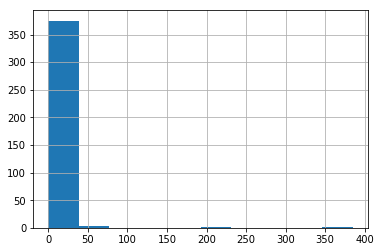

In [44]:
# absences — количество пропущенных занятий
stud_math.absences.hist()
stud_math.absences.describe()

In [45]:
# Видим, что 3/4 учеников проспукали не больше 8 занятий. Но также присутствуют крайне большие значения.
# Возможно это означает, что ученики совсем не ходили на занятия, но т.к. местами количество пропусков больше чем возможное кол-во
# занятий, это можно считать выбросами. Предположим, что в году было 200 занятий. На часть они все же сходили
stud_math.drop(stud_math[stud_math.absences > 100].index, inplace=True)

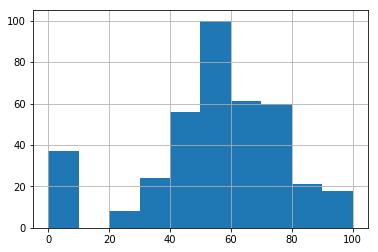

In [46]:
# Видим, что 3/4 учеников проспукали не больше 8 занятий. Но также присутствуют крайне большие значения.
# Возможно это означает, что ученики совсем не ходили на занятия. Можно в дальнейшем узнать как это влияет на оценку
stud_math.score.hist()

In [47]:
stud_math['score'] = stud_math['score'].fillna('')

In [48]:
# Из графика видно, что большая часть (100) студентов получила оценку от 50 до 60 баллов.
# Также многие получили 0 баллов. Возможно это означает, что студент не пришел на экзамен.
# Но нам такие данные в целом не нужны, можем их исключить
stud_math.drop(stud_math[stud_math.score == ''].index, inplace=True)
stud_math['score'] = stud_math['score'].astype(float)

In [49]:
# Поделим все столдцы на категориальные и количественные признаки
binary_list = ['school', 'sex', 'address', 'fam_size', 'p_status', 'reason', 'guardian', 'travel_time', 'study_time', 'failures', 'school_sup',
               'm_job', 'f_job', 'reason', 'guardian', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
quantitative_list = ['age', 'absences']
category_list = ['m_edu', 'f_edu', 'fam_rel', 'free_time',
                 'go_out', 'health', 'travel_time', 'failures']

In [50]:
# Проверим корреляцию возраста и количества пропусков на итоговую оценку
age_corr = stud_math['age'].corr(stud_math['score'])
absences_corr = stud_math['absences'].corr(stud_math['score'])
print(age_corr)
print(absences_corr)

-0.1535392531388198
0.03338512559847826


In [51]:
# Оба показателя практически не коррелируются с итоговой оценкой

In [52]:
# Построим боксплоты для отображения категориальных признаков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='score',
                data=stud_math.loc[stud_math.loc[:, column].isin(
                    stud_math.loc[:, column].value_counts().index[:6])],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [53]:
list_columns = stud_math.columns

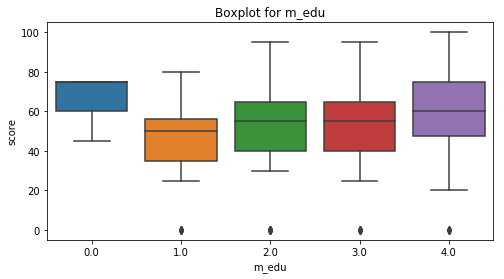

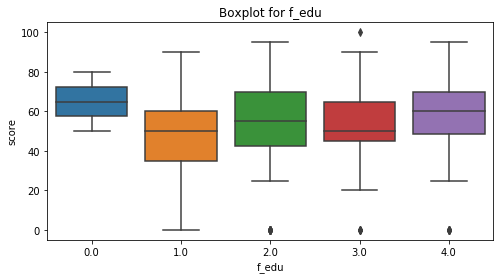

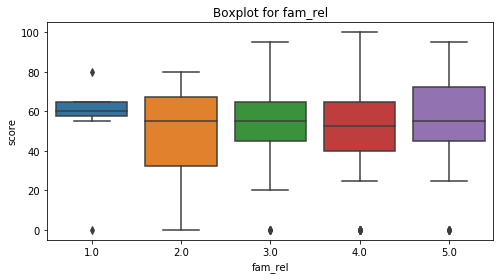

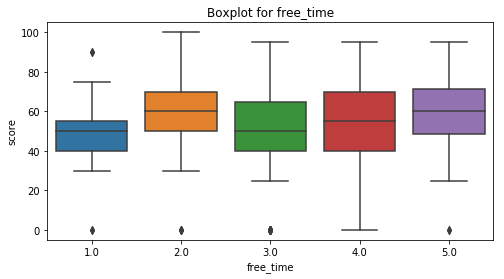

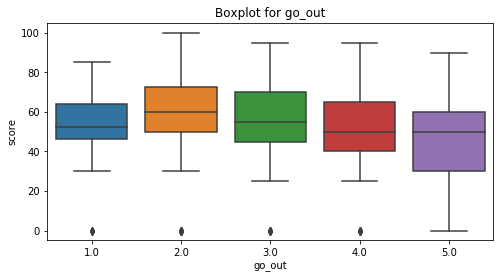

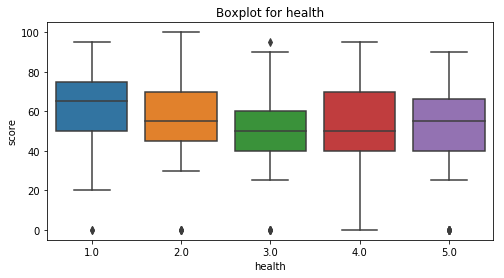

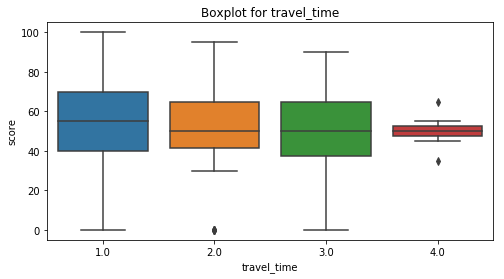

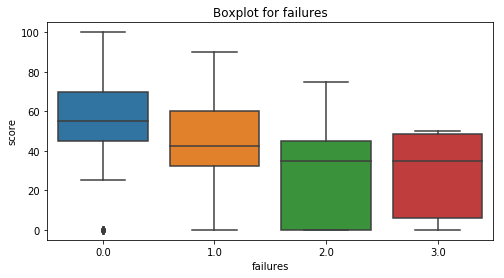

In [54]:
for col in category_list:
    get_boxplot(col)

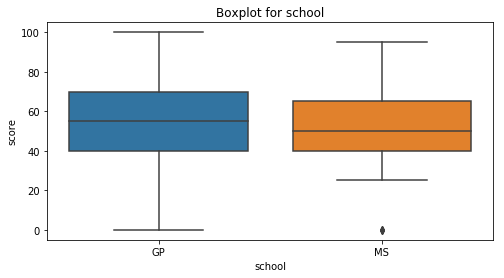

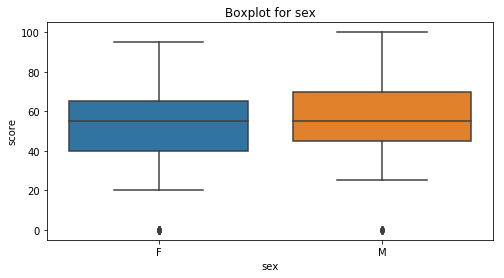

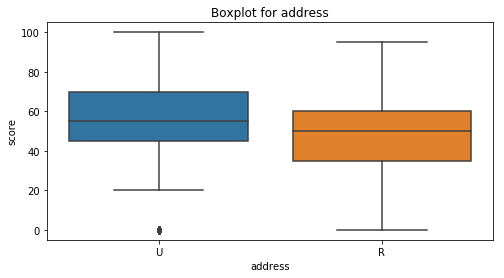

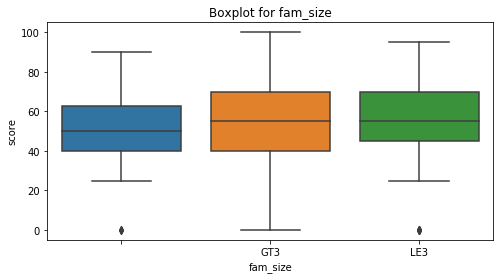

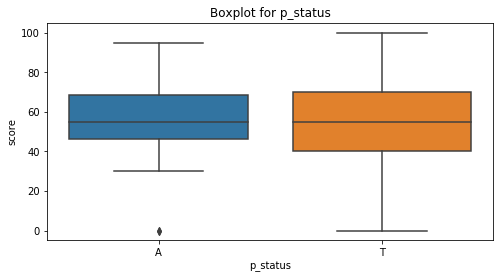

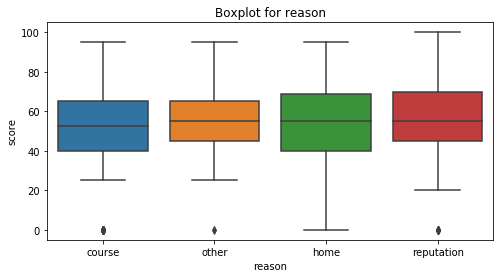

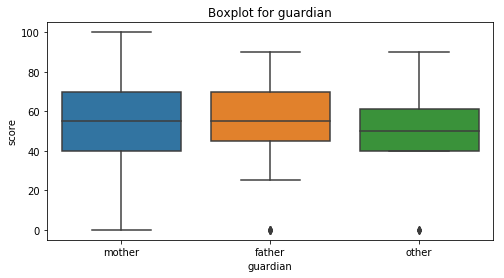

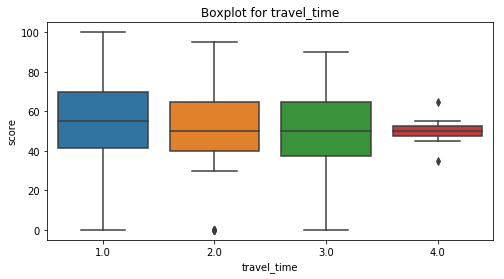

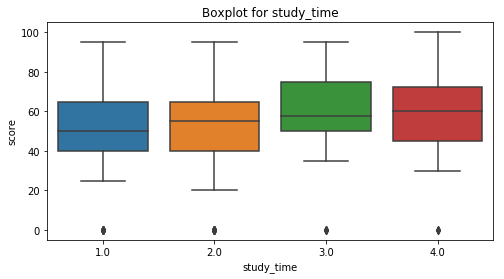

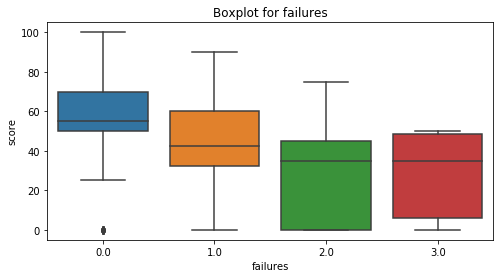

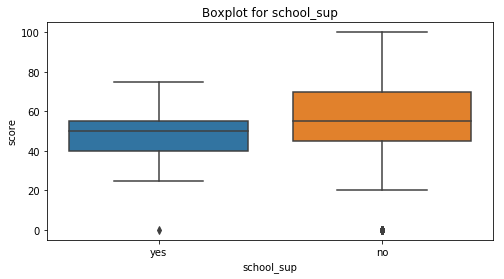

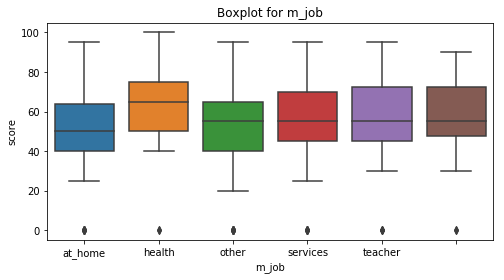

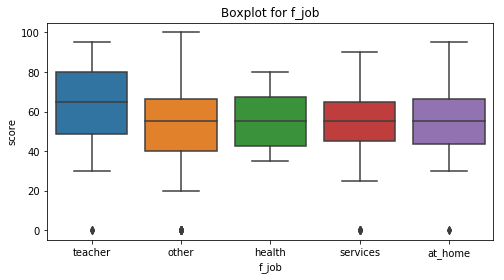

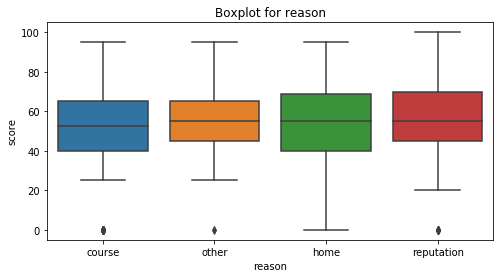

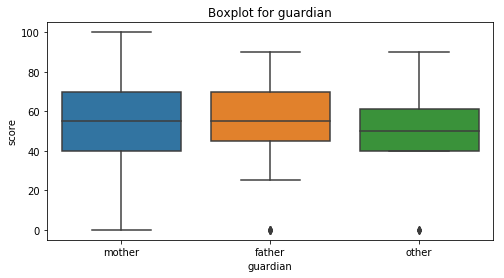

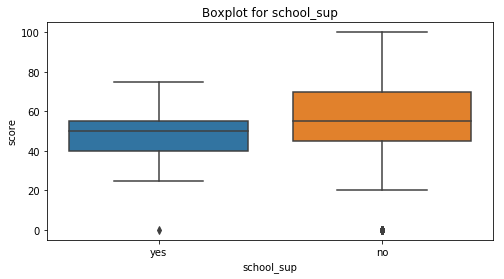

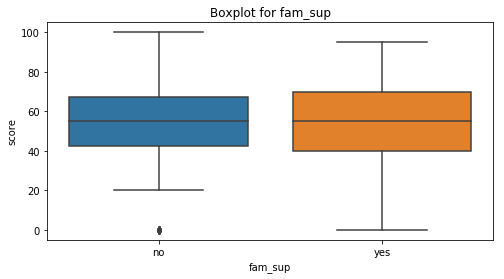

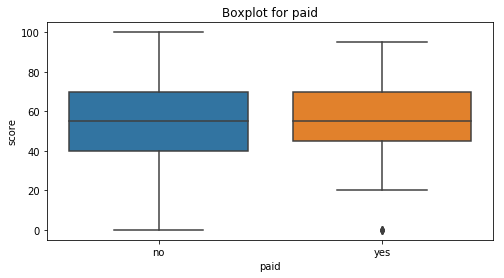

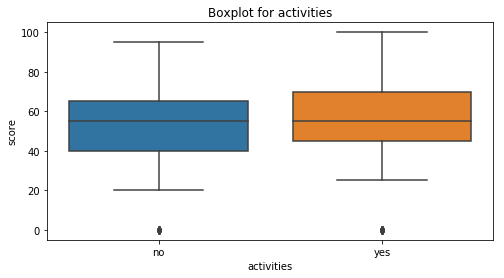

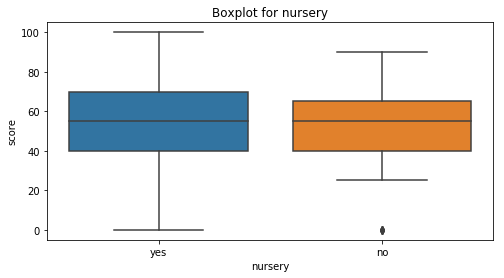

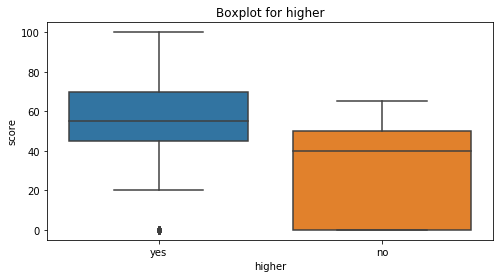

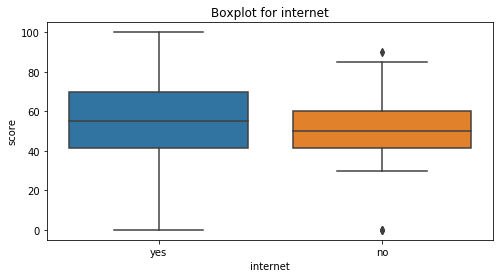

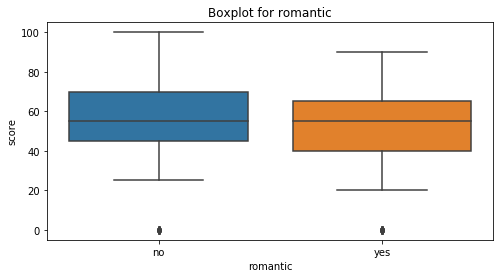

In [520]:
for col in binary_list:
    get_boxplot(col)

In [55]:
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [56]:
for col in (category_list):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки go_out
Найдены статистически значимые различия для колонки failures


In [57]:
for col in (binary_list):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Выводы:
В выборке присутствует некоторое количество пустых значений. Где выборка была сильно смещена в к одному из показателей, мы смогли заполнить пустые ячейки.
Выброс очень мало, поэтому можно в увереностью сказать, что выборка чистая
К сожалению корреляционный анализ не показал влияния возраста или количества пропусков на итоговую оценку.
В дальнейшем моэжно использовать параменты образование матери, проведение времени с друзьями, количество внеучебных неудач, пол, тип адреса ученика,  дополнительные платные занятия по математике, желание получить высшее образование и, как ни печально, состояние в романтических отношениях.